In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import ListedColormap
import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)
import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp

import pickle
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


from os.path import isfile
import json



# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config):
    with open(path_config, 'r') as f:
        config = json.load(f)
else:
    with open("../config_default.json", 'r') as f:
        config = json.load(f)

path_figures = config["path_figures"]
print(path_figures)




In [2]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
    'facecolor': 'none',
    'bbox_inches': 'tight',
    'pad_inches': 0
}

#mm to inches conversion
def mm_to_inches(mm):
    return mm / 25.4

#colormap for raster plot
colors = [(0, 0, 0, 0),  
          (0, 0, 0.55, 1)]  
cmap = ListedColormap(colors)

In [3]:
#random network implementation
def random_graph(N, k, J, seed=100, weights='homogeneous', weight_generator=None):
    '''
    Creates a random, directed, and weighted Erdos Renyi graph.
    Parameters:
        N: number of nodes
        k: mean nodal degree
        J: weight parameters. If homogeneous weights: constant float, if gaussian weigts: J=(J_mean, J_sigma)
        seed: seed for the ER graph generation
        weights: Type of weights, 'homogeneous' or 'gaussian'
        generator: random generator for random weights
    Returns:
        sparse jax.experimental coupling matrix 
    '''
    p = k / (N - 1)
    
    # Create ER graph
    G = nx.erdos_renyi_graph(N, p, directed=True, seed=seed)
    
    # Put weights
    for u, v in G.edges():
        if weights=='homogeneous':
            G[u][v]['weight'] = J#generator.normal(J, J/5)
        elif weights=='gaussian':
            G[u][v]['weight'] = weight_generator.normal(J[0], J[1])
    
    # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return sparse.BCSR.from_scipy_sparse(adj_matrix)

In [4]:


k=50
m=0.0005 # Mean J/k
N=1000
L= random_graph(N, k, J=m/k, weights='homogeneous')
@jit
def FHN_step(u, v, N, a, b, e,  sigma, L, key, delta_t):
    
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) + (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='zeros', a=3, b=0.2, e=1e-2,  J=L, sigma=0.1, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    if y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = random.normal(random.PRNGKey(0), shape=(2*N,))*e
     
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)

    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)
    u_trajectory=u_trajectory[::10]
    v_trajectory=v_trajectory[::10]

    return u_trajectory, v_trajectory



C:\Users\pelli\AppData\Local\Temp\ipykernel_27832\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [5]:
#healthy brain simulation. Change sigma to get sparser spikes (lower limit to get spikes is around 0.045 /0.5)
m1 =0.005
L1= random_graph(N, k, J=m1/k, weights='homogeneous')
u_sol_health, v_sol_health = run_simulation(N=N, J=L1, a=3, b=0.2, e=0.01,  sigma=0.05, total_time=3000, key=random.PRNGKey(int(1000)))

u_sol_health=u_sol_health.T
u_sol_health_bin=jnp.where(u_sol_health>0.5, 1, 0)

C:\Users\pelli\AppData\Local\Temp\ipykernel_27832\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


## Raster plot

In [ ]:
# get rid of the transient and plot fewer neurons
# [N, T]
data_health =u_sol_health_bin[950:, 100:]



# Add blank rows between binary rows 
N1, T1 = data_health.shape
gap1 = 1  # Gap size (number of blank rows)
data_health_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data_health_with_blanks[i * (gap1 + 1), :] = data_health[i, :]




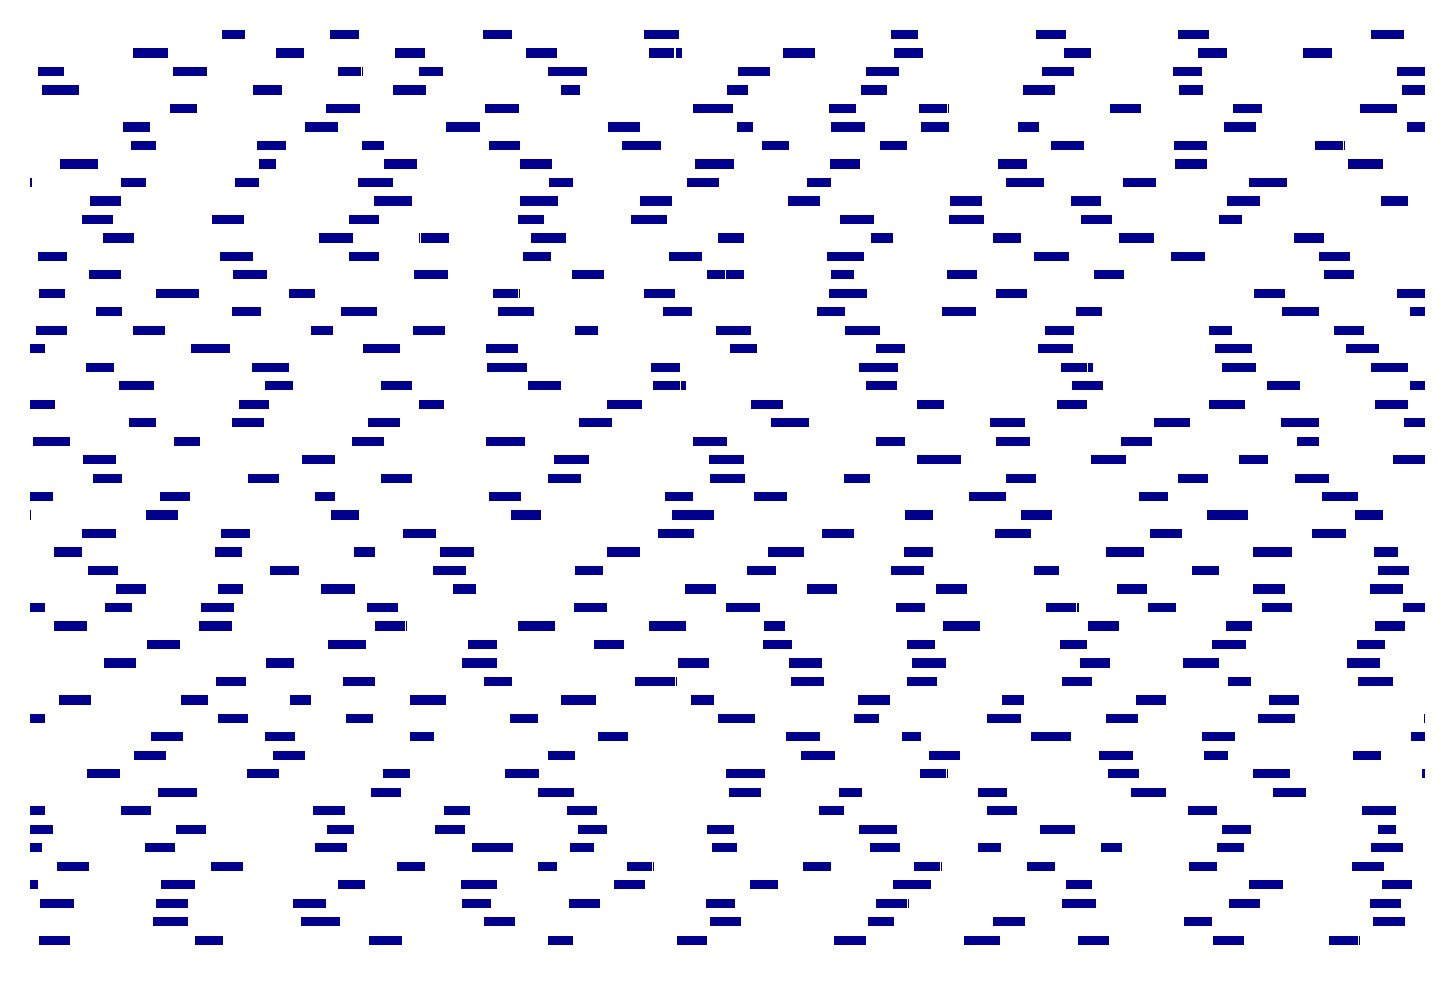

In [12]:
# Desired dimensions in mm
width_mm = 78
aspect_ratio = 6 / 4  # wanted aspect ratio
height_mm = width_mm / aspect_ratio


# Plot the data
plt.figure(figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)

plt.imshow(data_health_with_blanks, cmap=cmap, interpolation='none',  aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([]) 
#plt.ylabel("Excitable cells ", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig(path_figures+'brain_raster_asynchronous.pdf', **savefig_args)



## EEG

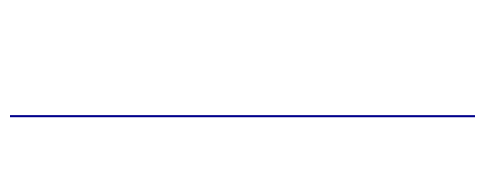

In [17]:
#here the y scale is set to match the one of the heart simulation
fig, ax = plt.subplots( figsize=(6, 2), facecolor='none')
EEG=u_sol_health[ :, 100:].sum(axis=0)/10000
ax.plot(EEG, color='darkblue')

ax.set_ylim([-0.09,0.24])
ax.set_xlim(0,1)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig(path_figures+'brain_EEG_asynchro.pdf', **savefig_args)

In [ ]:
# inset EEG
fig, ax = plt.subplots( figsize=(6, 2), facecolor='none')
EEG=u_sol_health[ :, 2000:].sum(axis=0)/10000
ax.plot(EEG, color='darkblue')


ax.set_xlim(0)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig(path_figures+'brain_EEG_asynchro_inset.pdf', **savefig_args)